# 1. Imports

In [1]:
# Import libraries to verify installation
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image
from keras.utils import image_dataset_from_directory
import cv2
from PIL import Image
import random
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Check TensorFlow version to confirm it's installed
print("TensorFlow version:", tf.__version__)
print("All libraries are installed and working!")

import warnings
warnings.filterwarnings("ignore")


2024-05-07 12:00:21.233272: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-07 12:00:26.313142: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/intel/compilers_and_libraries_2018.1.163/linux/tbb/lib/intel64_lin/gcc4.7:/opt/intel/compilers_and_libraries_2018.1.163/linux/compiler/lib/intel64_lin:/opt/intel/compilers_and_libraries_2018.1.163/linux/mkl/lib/intel64_lin:/opt/intel/compilers_and_libraries_2018.1.163/linux/tbb/lib/intel64_lin/gcc4.7:/opt/intel/compilers_and_libraries_2018.1.163/linux/compiler/lib/intel64_lin:/opt/intel/co

TensorFlow version: 2.11.0
All libraries are installed and working!


In [4]:
# Import the dataset
train_directory = '/home/default/BirdSpecies/train'
test_directory = '/home/default/BirdSpecies/test'
validation_directory = '/home/default/BirdSpecies/valid'

In [5]:
train_img = [os.path.join(train_directory, f) for f in os.listdir(train_directory)]
test_img = [os.path.join(test_directory, f) for f in os.listdir(test_directory)]
valid_img = [os.path.join(validation_directory, f) for f in os.listdir(validation_directory)]

In [6]:
df_train = pd.read_csv("/Users/casparlehmkuhler/Desktop/Bird_Species_Identification/birds.csv")
df_train.head()

FileNotFoundError: [Errno 2] No such file or directory: '/Users/casparlehmkuhler/Desktop/Bird_Species_Identification/birds.csv'

# 2. Data Visualisation

We see that we have variying numbers of samples in the training set. In the test and validation sets, we have 5 samples each.

In [7]:
# Create an instance of ImageDataGenerator with desired augmentation parameters
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=25,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

# Flow images from directory using the defined data generator
train_generator = train_datagen.flow_from_directory(
    train_directory,
    target_size=(224,224),
    batch_size=150,
    class_mode='categorical',
    color_mode='rgb')

Found 84635 images belonging to 525 classes.


In [8]:
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(test_directory,
                                                    target_size=(224,224),
                                                    batch_size=64,
                                                    class_mode='categorical',
                                                    color_mode='rgb')

Found 2625 images belonging to 525 classes.


In [9]:
val_datagen=tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
val_generator = val_datagen.flow_from_directory(validation_directory,
                                                target_size=(224,224),
                                                batch_size=150,
                                                class_mode='categorical',
                                                color_mode='rgb')

Found 2625 images belonging to 525 classes.


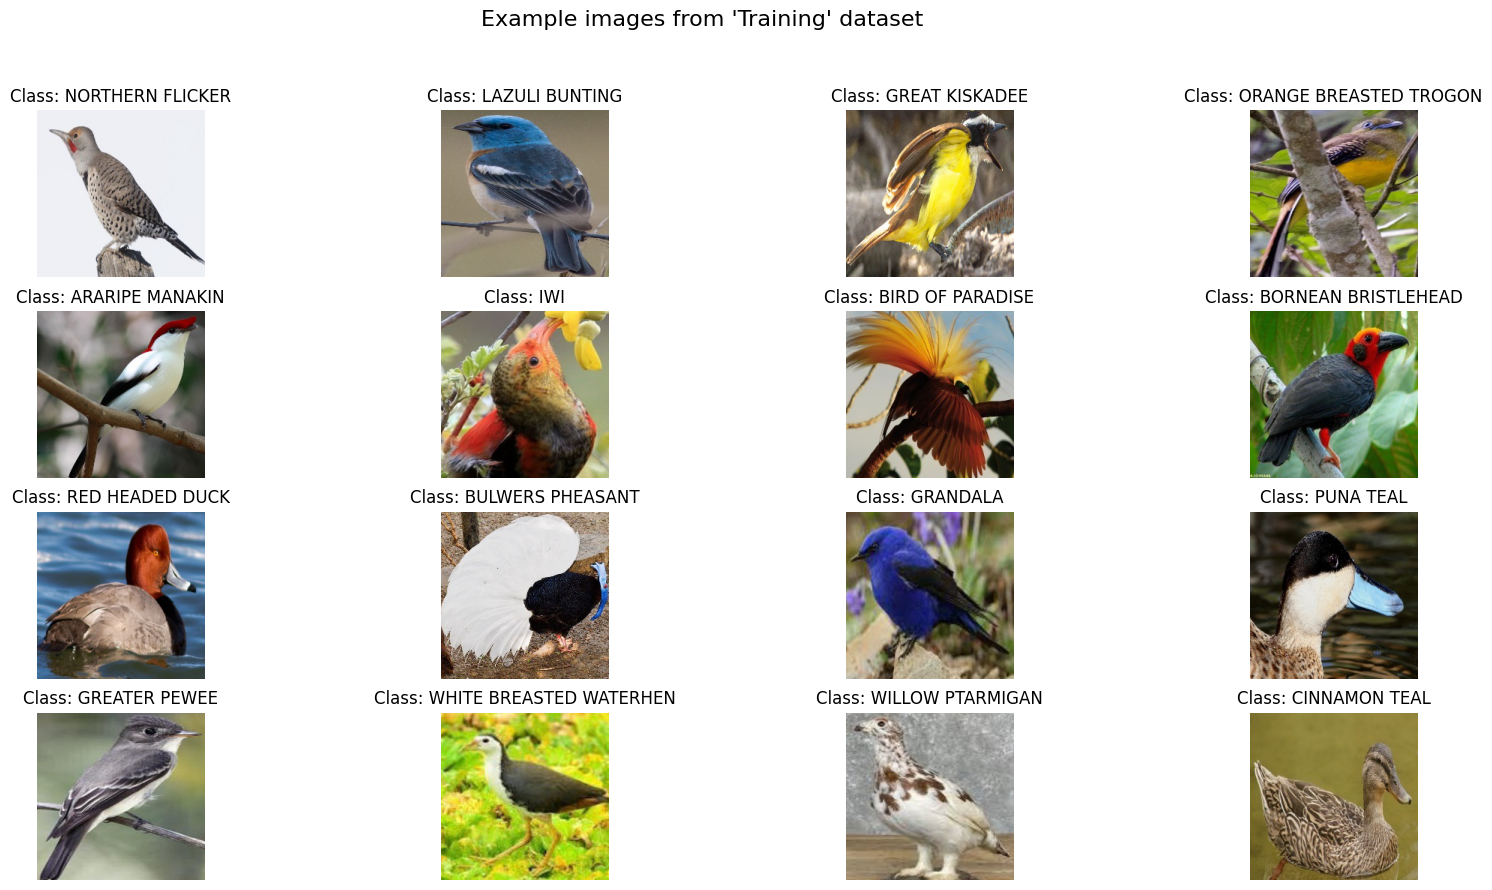

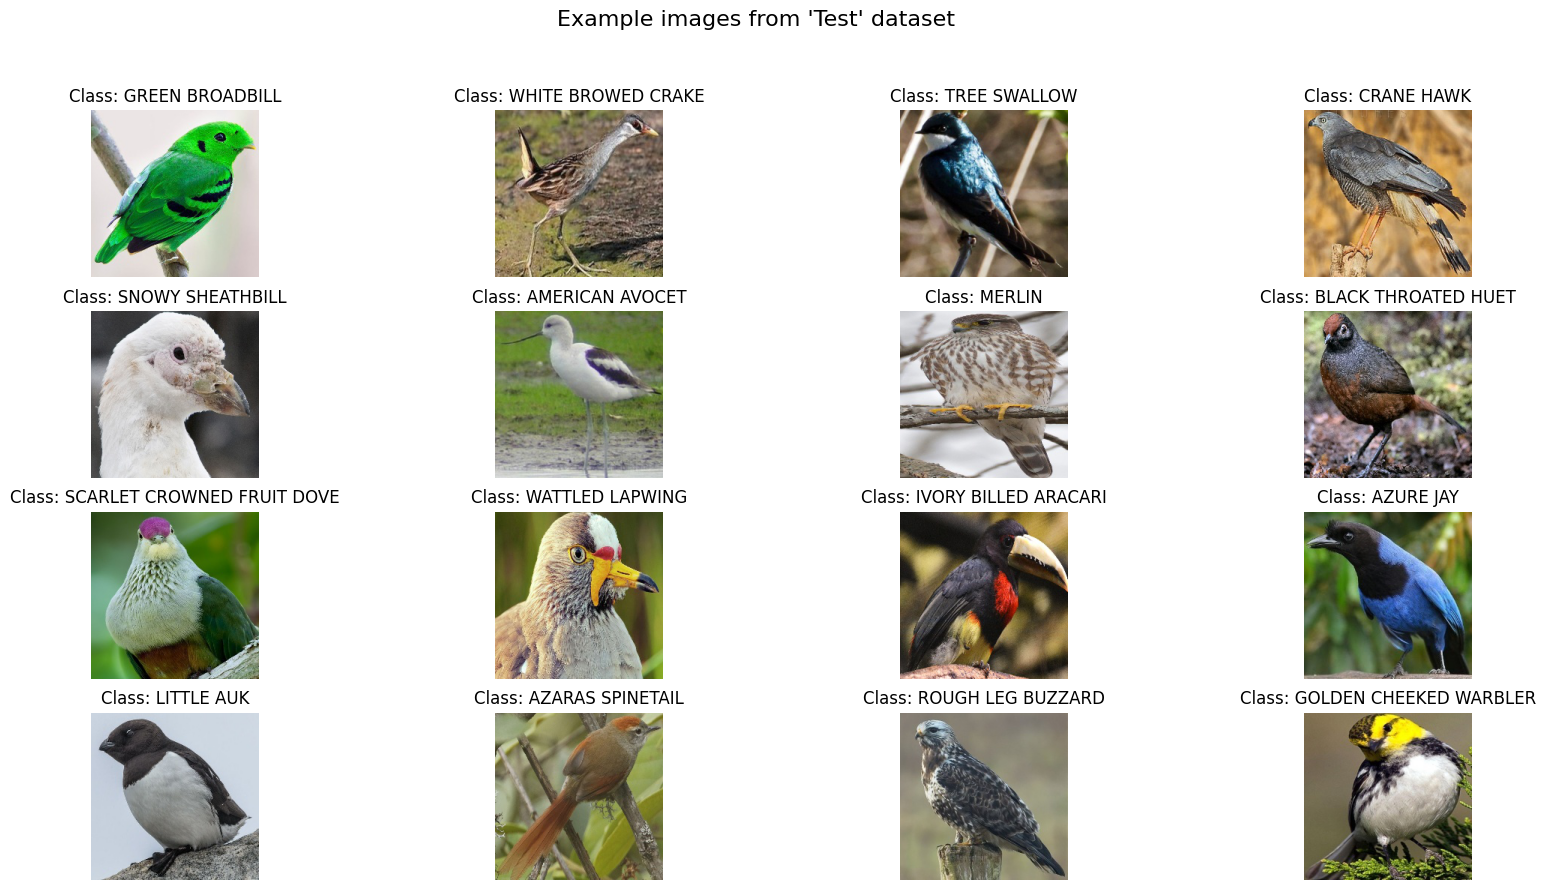

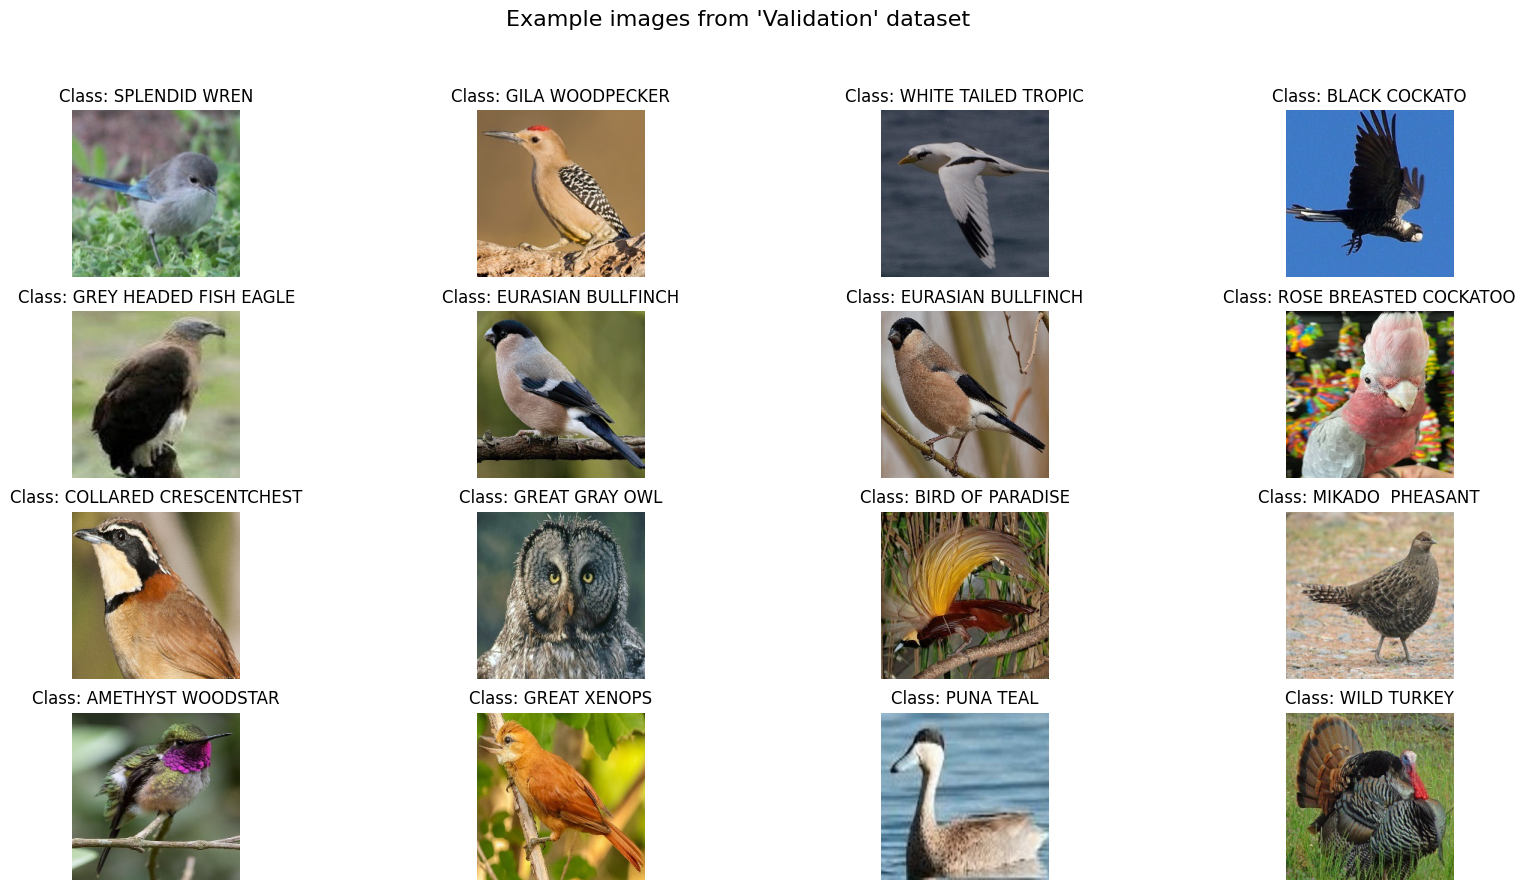

In [10]:
def visualize_data(data_directory, num_images, rows, class_names=None, dataset_name=None):
    plt.figure(figsize=(20, 10))
    if dataset_name:
        plt.suptitle(f"Example images from '{dataset_name}' dataset", fontsize=16)
    classes = os.listdir(data_directory)
    for i in range(num_images):
        # Randomly select a class (bird species)
        class_name = random.choice(classes)
        class_dir = os.path.join(data_directory, class_name)
        # Get a list of images in the class directory
        images = os.listdir(class_dir)
        # Randomly select an image from the class
        image_name = random.choice(images)
        image_path = os.path.join(class_dir, image_name)
        # Load and display the image
        image = Image.open(image_path)
        plt.subplot(rows, num_images // rows, i + 1)
        plt.imshow(image)
        plt.axis('off')
        if class_names is not None:
            plt.title(f"Class: {class_names[class_name]}")
        else:
            plt.title(f"Class: {class_name}")


# Define class names (if available)
class_names = {
    'class1': 'Species 1',
    'class2': 'Species 2',
    # Add more class mappings as needed
}

# Visualize the training data
visualize_data(train_directory, num_images=16, rows=4, dataset_name='Training')

# Visualize the test data
visualize_data(test_directory, num_images=16, rows=4, dataset_name='Test')

# Visualize the validation data
visualize_data(validation_directory, num_images=16, rows=4, dataset_name='Validation')



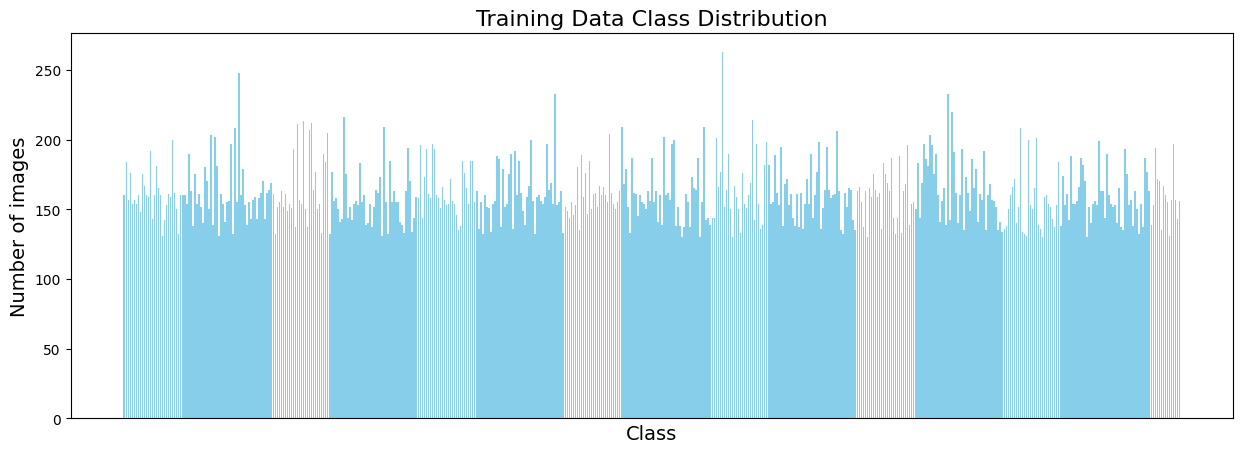

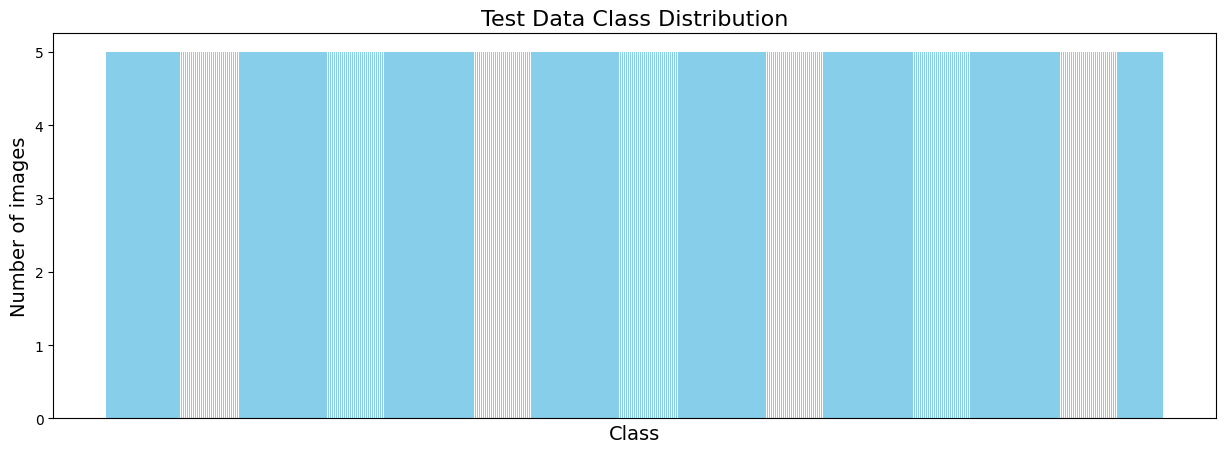

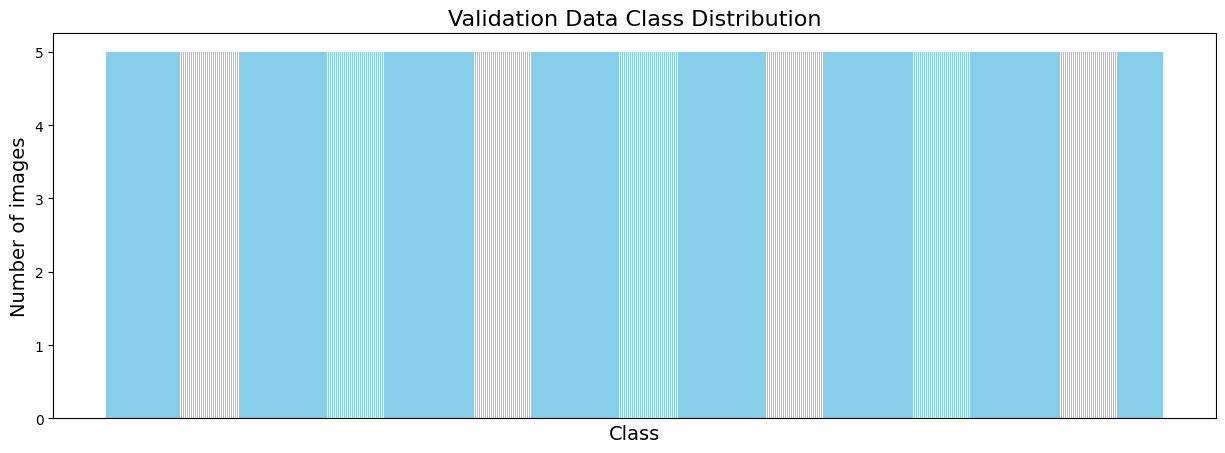

In [11]:
def plot_class_distribution(data_directory, title):
    # Filter out non-directory files (like .DS_Store)
    classes = [c for c in os.listdir(data_directory) if os.path.isdir(os.path.join(data_directory, c))]
    num_images = [len(os.listdir(os.path.join(data_directory, c))) for c in classes]
    plt.figure(figsize=(15, 5))
    plt.bar(classes, num_images, color='skyblue')
    plt.title(title, fontsize=16)
    plt.xlabel('Class', fontsize=14)
    plt.ylabel('Number of images', fontsize=14)
    plt.xticks([])
    plt.show()
# Plot the class distribution for the training data
plot_class_distribution(train_directory, title='Training Data Class Distribution')

# Plot the class distribution for the test data
plot_class_distribution(test_directory, title='Test Data Class Distribution')

# Plot the class distribution for the validation data
plot_class_distribution(validation_directory, title='Validation Data Class Distribution')


# 3. Model Selection & Training

### 3.1. CNN Model

In [12]:
conv_model = tf.keras.applications.EfficientNetV2S(
                    include_top=False,
                    weights='imagenet',
                    input_tensor=None,
                    pooling=None,
                    classes=525,
                    classifier_activation='softmax',
                    include_preprocessing=True,
                    input_shape=(224, 224, 3))
conv_model.trainable = False
conv_model.summary()

2024-05-07 12:09:55.439778: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /anaconda/envs/azureml_py38/lib/python3.8/site-packages/cv2/../../lib64:/opt/intel/compilers_and_libraries_2018.1.163/linux/tbb/lib/intel64_lin/gcc4.7:/opt/intel/compilers_and_libraries_2018.1.163/linux/compiler/lib/intel64_lin:/opt/intel/compilers_and_libraries_2018.1.163/linux/mkl/lib/intel64_lin:/opt/intel/compilers_and_libraries_2018.1.163/linux/tbb/lib/intel64_lin/gcc4.7:/opt/intel/compilers_and_libraries_2018.1.163/linux/compiler/lib/intel64_lin:/opt/intel/compilers_and_libraries_2018.1.163/linux/mkl/lib/intel64_lin::/usr/local/cuda/lib64:/usr/local/cuda/extras/CUPTI/lib64/:/usr/local/cuda/lib64:/usr/local/cuda/extras/CUPTI/lib64/
2024-05-07 12:09:55.439975: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loa

82420632/82420632 [==============================] - 3s 0us/step
Model: "efficientnetv2-s"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 224, 224, 3)  0           ['input_1[0][0]']                
                                                                                                  
 stem_conv (Conv2D)             (None, 112, 112, 24  648         ['rescaling[0][0]']              
                                )                                                                 
                  

In [13]:
model = tf.keras.models.Sequential()
model.add(conv_model)
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1024, activation="relu"))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(525, activation='softmax'))

In [14]:
model.compile(loss='categorical_crossentropy',optimizer="adam",metrics=['accuracy'])

callbacks = [
tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
    min_delta = 0.001,
    mode="max",
    patience = 10,
    verbose = 1,
    restore_best_weights = True),
    
tf.keras.callbacks.ModelCheckpoint(
    filepath='./model.keras',
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)]

In [15]:
history = model.fit(
    train_generator,
    epochs=30,
    callbacks=callbacks,
    validation_data=val_generator,
    batch_size=32)


Epoch 1/30
  4/565 [..............................] - ETA: 1:02:09 - loss: 36.4278 - accuracy: 0.0017

KeyboardInterrupt: 

In [ ]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]

epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Tranning_acc", color = "red")
plt.plot(epochs, val_acc, "b", label="validation_acc", color = "blue")
plt.legend()
plt.show()

In [ ]:
score = model.evaluate(val_generator,batch_size=32)
print("Accuracy: {:.2f}%".format(score[1] * 100)) 
print("Loss: ",score[0])

In [ ]:
saved_model = tf.keras.models.load_model('./model.keras')
saved_model

### 3.2. Something else

In [38]:
# Define constants
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
EPOCHS = 10

# Data preprocessing and augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

train_generator = train_datagen.flow_from_directory(
    train_directory,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

validation_datagen = ImageDataGenerator(rescale=1./255)

validation_generator = validation_datagen.flow_from_directory(
    validation_directory,
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

# Get the number of classes
NUM_CLASSES = len(train_generator.class_indices)

# Build the CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(NUM_CLASSES, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator
)

# Evaluate the model on the test data
loss, accuracy = model.evaluate(test_generator)

print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')


Found 84635 images belonging to 525 classes.
Found 2625 images belonging to 525 classes.
Epoch 1/10
1506/2645 ━━━━━━━━━━━━━━━━━━━━ 3:48 200ms/step - accuracy: 0.0047 - loss: 6.2171

KeyboardInterrupt: 

In [45]:
import torch
from tqdm import tqdm

def move_to_device(module, device):
    if isinstance(module, torch.nn.Module):
        module.to(device)

def move_model_to_device(model, device):
    for module in model:
        move_to_device(module, device)

def train_setup(model, tr_dl, val_dl, epochs=10, device="cuda", patience=4, lr=3e-4):
    # Move the entire model to the device
    move_model_to_device(model, device)
    
    loss_fn = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(params=model.parameters(), lr=lr)
    
    best_val_loss = float('inf')
    best_val_acc = 0
    improvement = 0
    
    train_losses, train_accs = [], []
    val_losses, val_accs = [], []

    for epoch in range(epochs):
        epoch_loss, epoch_acc, total = 0, 0, 0

        # Training loop
        model.train()
        for idx, batch in tqdm(enumerate(tr_dl)):
            ims, gts = batch
            ims, gts = ims.to(device), gts.to(device)
            total += ims.shape[0]

            # Forward pass
            preds = model(ims)
            loss = loss_fn(preds, gts)

            # Backpropagation
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            _, pred_cls = torch.max(preds.data, dim=1)
            epoch_acc += (pred_cls == gts).sum().item()
            epoch_loss += loss.item()

        # Calculate average training loss and accuracy for the epoch
        tr_loss = epoch_loss / len(tr_dl)
        train_losses.append(tr_loss)
        train_accs.append(epoch_acc / total)

        print(f"Epoch {epoch + 1} train process is finished")
        print(f"Epoch {epoch + 1} train loss -> {tr_loss:.3f}")
        print(f"Epoch {epoch + 1} train accuracy -> {epoch_acc / total:.3f}")

        # Validation loop
        model.eval()
        with torch.no_grad():
            val_epoch_loss, val_epoch_acc, val_total = 0, 0, 0
            for idx, batch in enumerate(val_dl):
                ims, gts = batch
                ims, gts = ims.to(device), gts.to(device)
                val_total += ims.shape[0]

                # Forward pass
                preds = model(ims)
                loss = loss_fn(preds, gts)

                _, pred_cls = torch.max(preds.data, dim=1)
                val_epoch_acc += (pred_cls == gts).sum().item()
                val_epoch_loss += loss.item()

            # Calculate average validation loss and accuracy for the epoch
            val_loss = val_epoch_loss / len(val_dl)
            val_acc = val_epoch_acc / val_total
            val_losses.append(val_loss)
            val_accs.append(val_acc)

            print(f"Epoch {epoch + 1} validation is finished")
            print(f"Epoch {epoch + 1} validation loss -> {val_loss:.3f}")
            print(f"Epoch {epoch + 1} validation accuracy -> {val_acc:.3f}")

            # Save the model if the validation loss has improved
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_val_acc = val_acc
                improvement = 0
                torch.save(model.state_dict(), 'best_val.pth')
            else:
                improvement += 1
                if improvement >= patience:
                    print(f"No improvement in validation loss for {patience} epochs. Stopping early.")
                    break
    
    return model, train_losses, train_accs, val_losses, val_accs

# Usage example:
# model, train_losses, train_accs, val_losses, val_accs = train_setup(model, train_generator, validation_generator, epochs=10, device="cuda", patience=4, lr=3e-4)

model, train_losses, train_accs, val_losses, val_accs = train_setup(model, train_generator, validation_generator, epochs=10, device="cuda", patience=4, lr=3e-4)


TypeError: 'Sequential' object is not iterable